1. AKAZE - 특징점 검출 알고리즘 객체 생성
2. BFMatcher_create(cv2.NORM_HAMMING) / knnMatch - 특징점 매칭

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# of kp1: 81
# of kp2: 148
# of matches: 81
# of good_matches: 80


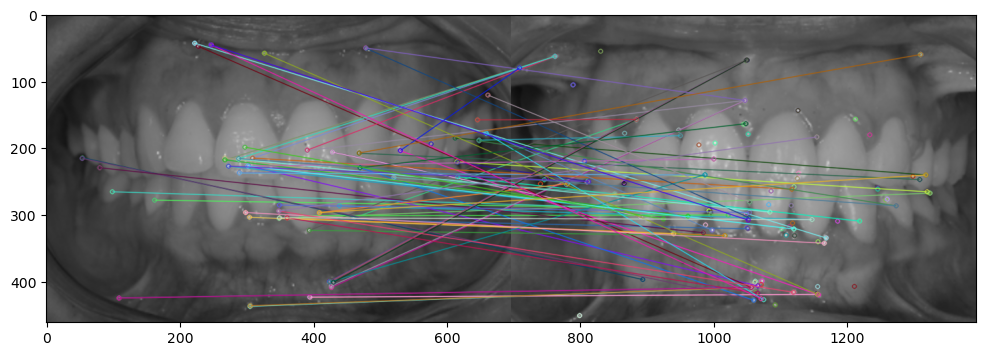

In [2]:
# 영상 불러오기
b_img = cv2.imread('/home/tkd_010/ImageProcessing/study/image_registeration/before.png')
a_img = cv2.imread('/home/tkd_010/ImageProcessing/study/image_registeration/after.png')

# b_img = cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB)
# a_img = cv2.cvtColor(a_img, cv2.COLOR_BGR2RGB)

b_gray = cv2.cvtColor(b_img, cv2.COLOR_BGR2GRAY)
a_gray = cv2.cvtColor(a_img, cv2.COLOR_BGR2GRAY)


# 특징점 알고리즘 객체 생성 (KAZE, AKAZE, ORB 등)
feature = cv2.KAZE_create()
# feature = cv2.AKAZE_create()
# feature = cv2.ORB_create()

# 특징점 검출 및 기술자 계산
kp1, desc1 = feature.detectAndCompute(b_gray, None)
kp2, desc2 = feature.detectAndCompute(a_gray, None)

# 특징점 매칭
matcher = cv2.BFMatcher_create()
# matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)
# matches = matcher.knnMatch(desc1, desc2, 4) # knnMatch로 특징점 4개 검출
matches = matcher.match(desc1, desc2) # knnMatch로 특징점 4개 검출

# 좋은 매칭 결과 선별
# match 사용한 경우
matches = sorted(matches, key=lambda x: x.distance)
good_matches = matches[:80]

# knn 사용한 경우
# good_matches = []
# for m in matches: # matches는 4개의 리스트로 구성
#     if m[0].distance / m[1].distance < 0.7: # 임계점 0.7
#         good_matches.append(m[0]) # 저장
        
        
        
print('# of kp1:', len(kp1))
print('# of kp2:', len(kp2))

print('# of matches:', len(matches))
print('# of good_matches:', len(good_matches))

# 특징점 매칭 결과 영상 생성
dst = cv2.drawMatches(b_gray, kp1, a_gray, kp2, good_matches, None)

plt.figure(figsize=(12,10))
plt.imshow(dst)
plt.show()

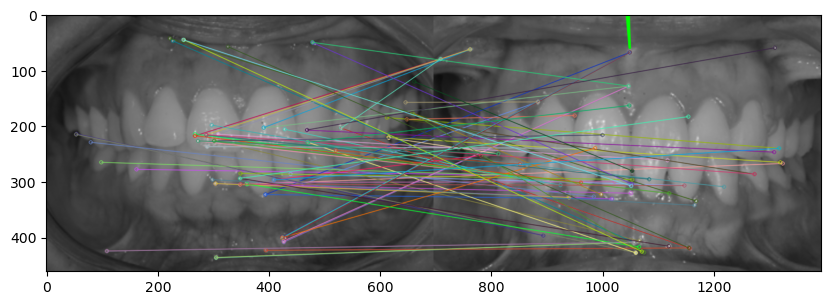

In [5]:
# 호모그래피 계산
# DMatch 객체에서 queryIdx와 trainIdx를 받아와서 크기와 타입 변환하기
pts1 = np.array([kp1[m.queryIdx].pt for m in good_matches]
				).reshape(-1, 1, 2).astype(np.float32)

pts2 = np.array([kp2[m.trainIdx].pt for m in good_matches]
				).reshape(-1, 1, 2).astype(np.float32)
                
H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC) # pts1과 pts2의 행렬 주의 (N,1,2)


# 호모그래피를 이용하여 기준 영상 영역 표시
dst = cv2.drawMatches(b_gray, kp1, a_gray, kp2, good_matches, None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

(h, w) = b_gray.shape[:2]

# 입력 영상의 모서리 4점 좌표
corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]
                    ).reshape(-1, 1, 2).astype(np.float32)

# 입력 영상에 호모그래피 H 행렬로 투시 변환
corners2 = cv2.perspectiveTransform(corners1, H)
# corners2는 입력 영상에 좌표가 표현되있으므로 입력영상의 넓이 만큼 쉬프트
corners2 = corners2 + np.float32([w, 0])


# # 다각형 그리기
cv2.polylines(dst, [np.int32(corners2)], True, (0, 255, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(10,8))
plt.imshow(dst)
plt.show()

# plt.imshow(img_output)
# plt.show()

In [123]:
int(np.linalg.norm(pts1[0] - pts2[0]))

148

(80, 2)

## 일단 돌려보자 - 점 4개 => perspective transformation
### 돼?? 그러면 아까 부족했던 비슷한 점을 제외시키는 알고리즘을 짜자
## pts를 다 int8로 고치고  --->   set으로 유일한 점에 대해서만 list를 만들자  --->  점이 중복되지 않도록

In [8]:
diff = []
index_diff=[]
min_val = 1000
# pts1 = pts1.astype("uint8")
# pts2 = pts2.astype("uint8")

for j, i in enumerate(range(len(pts1))):
    d = np.linalg.norm(pts1[i] - pts2[i])
    diff.append(d)
    index_diff.append((d, j))
    
# index_diff = np.array(index_diff)

# sorted(index_diff)

short_diff = sorted(index_diff)[1:5]
short_diff

[(3.3762548, 37), (10.705285, 63), (13.259479, 44), (23.507841, 1)]

In [9]:
short_idx =  [idx for d, idx in short_diff]
short_idx

[37, 63, 44, 1]

In [10]:
best_pts1 = pts1[short_idx]
best_pts2 = pts2[short_idx]

best_pts1, best_pts2

(array([[[289.4167 , 237.34187]],
 
        [[301.87296, 227.15169]],
 
        [[349.46695, 285.5305 ]],
 
        [[439.47452, 286.5353 ]]], dtype=float32),
 array([[[290.2367 , 240.61703]],
 
        [[303.47903, 216.56757]],
 
        [[356.78503, 296.5876 ]],
 
        [[450.74847, 307.16336]]], dtype=float32))

In [11]:
best_pts1[0,0,0], best_pts1[0,0,1]

(289.4167, 237.34187)

In [181]:
best_pts1.shape

(4, 1, 2)

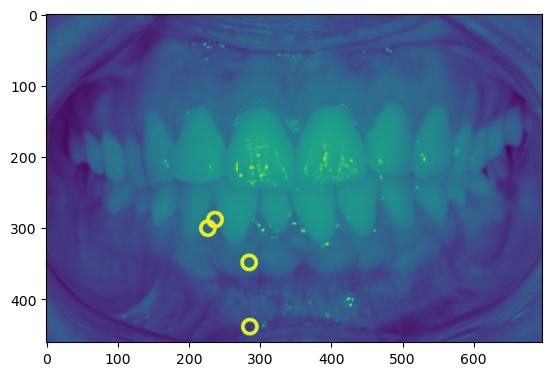

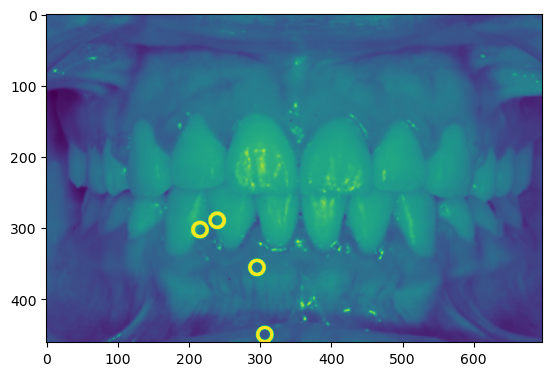

In [12]:
b_ = b_gray.copy()
a_ = a_gray.copy()

def draw_circle(src, x, y):
    cv2.circle(src, center=(int(x), int(y)), radius=10, color=(255, 0, 0), thickness=3, lineType=cv2.LINE_AA)
    
draw_circle(b_, best_pts1[0,0,1],best_pts1[0,0,0])
draw_circle(b_, best_pts1[1,0,1],best_pts1[1,0,0])
draw_circle(b_, best_pts1[2,0,1],best_pts1[2,0,0])
draw_circle(b_, best_pts1[3,0,1],best_pts1[3,0,0])

draw_circle(a_, best_pts2[0,0,1],best_pts2[0,0,0])
draw_circle(a_, best_pts2[1,0,1],best_pts2[1,0,0])
draw_circle(a_, best_pts2[2,0,1],best_pts2[2,0,0])
draw_circle(a_, best_pts2[3,0,1],best_pts2[3,0,0])

plt.imshow(b_)
plt.show()

plt.imshow(a_)
plt.show()

<class 'numpy.ndarray'>
[[-2.71607607e-01 -2.43433442e+00  5.27546274e+02]
 [ 2.62717067e-01 -2.63834195e+00  4.43348634e+02]
 [ 1.12401321e-03 -7.45418697e-03  1.00000000e+00]]


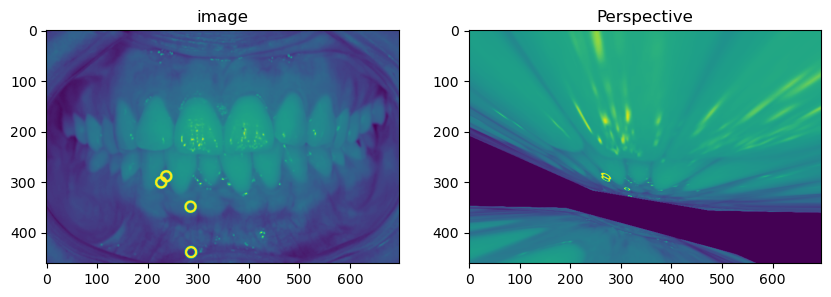

In [15]:
M = cv2.getPerspectiveTransform(best_pts1, best_pts2)
print(type(M))
print(M)

dst = cv2.warpPerspective(b_, M, (b_.shape[1],b_.shape[0]))

plt.figure(figsize=(10,8))
plt.subplot(121),plt.imshow(b_),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Perspective')
plt.show()

#### findHomography를 적용해보자  (매칭점 여러쌍을 기반으로 homography를 찾음)

In [16]:
diff = []
index_diff=[]

for j, i in enumerate(range(len(pts1))):
    d = np.linalg.norm(pts1[i] - pts2[i])
    diff.append(d)
    index_diff.append((d, j))
    

short_diff = sorted(index_diff)[1:5]
short_idx =  [idx for d, idx in short_diff]

best_pts1 = pts1[short_idx]
best_pts2 = pts2[short_idx]


H, _ = cv2.findHomography(best_pts1, best_pts2, cv2.RANSAC)

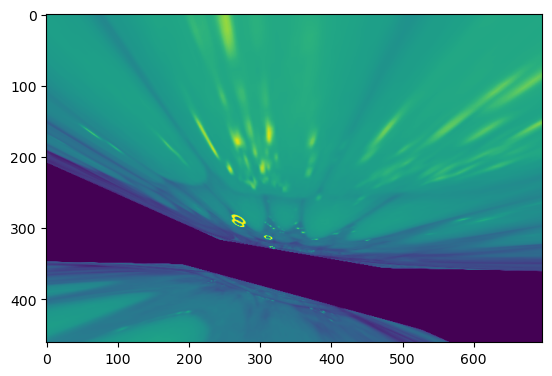

In [17]:
(h, w) = b_.shape[:2]


corners2 = cv2.perspectiveTransform(best_pts2, H)



plt.imshow(dst)
plt.show()